<a href="https://colab.research.google.com/github/volom/DS_ModelSelection/blob/main/scikit_fuzzy_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Scikit-Fuzzy Demo

##Procedure
In this demo we're going to translate a conceptual example, predicting expected customers in an ice cream shop given a particular outside temperature. This example modified from [Fuzzy Logic in Decision Making and Signal Processing](http://enpub.fulton.asu.edu/powerzone/fuzzylogic/chapter%205/frame5.htm) by Pant and Holbert.

Recall fuzzy systems consist of:

* **if** premise (antecedent) **then** conclusion (consequent) 

Consider an ice cream parlor, with a non-computer literate proprietor. He tells you:

* **if** temperature is hot **then** ice cream parlor is crowded.
* **if** temperature is moderate **then** ice cream parlor is busy.
* **if** temperature is cool **then** ice cream parlor is quiet.

For this system we have two universe variables: `temp` and `n_customers`.

Note how pythonic, simple, and intuitive this system is!

In [3]:
!pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 KB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=000e0f9ab181267b931d19ef27d6d5184c0fbaa01bab0fd127daf59e11454b18
  Stored in directory: /root/.cache/pip/wheels/2c/04/80/7eefb1a2de7d36aefd06432fab2a1486caf0a0596a7067391a
Successfully built scikit-fuzzy


In [23]:
# Import NumPy and scikit-fuzzy
import numpy as np
import matplotlib as plt
import skfuzzy as fuzz

In [20]:
def celcium(f):
    return (f-32)/1.8

In [22]:
celcium(20), celcium(65), celcium(30)

(-6.666666666666666, 18.333333333333332, -1.1111111111111112)

##Describe Fuzzy System

First create fuzzy membership functions which represent *degree of truth* related to a continuous variable variable.

In [5]:
# Generate universe functions
temp = np.arange(30, 101, 1)
customers = np.arange(0, 36, 1)

# Membership functions for heat
t_hot = fuzz.trimf(temp, [65, 100, 100])
t_moderate = fuzz.trimf(temp, [30, 65, 100])
t_cool = fuzz.trapmf(temp, [20, 20, 30, 65])

# Membership functions for customers
c_crowded = fuzz.trimf(customers, [24, 35, 35])
c_busy = fuzz.trimf(customers, [0, 24, 35])
c_quiet = fuzz.trimf(customers, [0, 0, 24])

**Note**: In scikit-fuzzy, all membership functions are raw NumPy arrays. This means in many functions you must manually specify both the universe variable (here `temp`) and the membership function. The universe variable and membership function arrays must have identical `shape`.

##Visualize Fuzzy System

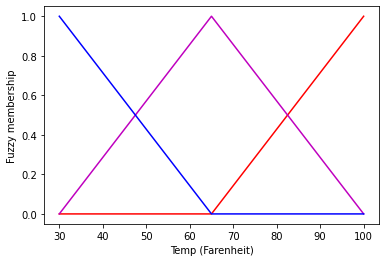

In [6]:
# Visualize membership functions for temperature
fig, ax = plt.subplots()

ax.plot(temp, t_hot, 'r', temp, t_moderate, 'm', temp, t_cool, 'b')
ax.set_ylabel('Fuzzy membership')
ax.set_xlabel('Temp (Farenheit)')
ax.set_ylim(-0.05, 1.05);

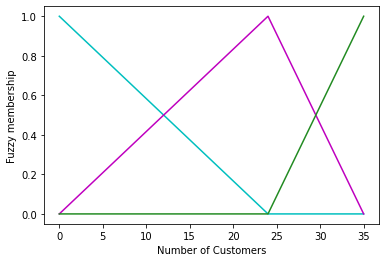

In [7]:
# Visualize membership functions for customers
fig, ax = plt.subplots()

ax.plot(customers, c_quiet, 'c', customers, c_busy, 'm', customers, c_crowded, 'ForestGreen')
ax.set_ylabel('Fuzzy membership')
ax.set_xlabel('Number of Customers')
ax.set_ylim(-0.05, 1.05);

Next, we use fuzzy implication via the Product (Larsen) relation, `fuzz.relation_product`. This is done separately for each statement in the fuzzy system, so we'll have 3 separate fuzzy relation matrices.

Note: scikit-fuzzy includes a second fuzzy implication relation, min (Mamdani) relation, as `fuzz.relation_min`

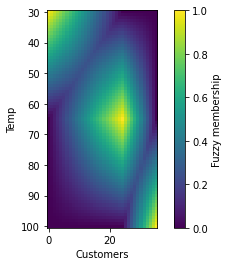

In [8]:
# Fuzzy relation
R1 = fuzz.relation_product(t_hot, c_crowded)
R2 = fuzz.relation_product(t_moderate, c_busy)
R3 = fuzz.relation_product(t_cool, c_quiet)

# Combine fuzzy relations into aggregate relation
R_combined = np.fmax(R1, np.fmax(R2, R3))

# Visualize 
plt.imshow(R_combined)
cbar = plt.colorbar()
cbar.set_label('Fuzzy membership')
plt.yticks([i * 10 for i in range(8)], [str(i * 10 + 30) for i in range(8)]);
plt.ylabel('Temp')
plt.xlabel('Customers');

###Defuzzification

The fuzzy relation matrices show how the system responds for all temperatures and all customers. But we need to make a specific prediction for a specific temperature. We need to return from the fuzzy domain back to crisp logic. **This is known as defuzzification**. 

Let's say it is 75 degrees outside (wishing here in Austin, I know). How many customers should the ice cream parlor expect?

In [9]:
# Note R_combined is zero-indexed, but the universe variable temp starts at 30... not zero.
fuzz.defuzz(customers, R_combined[temp == 75], 'centroid')

20.166917293233077

So about 20 people are predicted. Seem reasonable? Sure, but it doesn't tell us much. Let's get greedy and defuzzify the entire relation, to get a better intuitive sense of what is going on. 

The result of this step is effectively a look-up table, which need only be consulted - not re-calculated! - on future days, unless the model membership functions were adjusted.

In [10]:
# Defuzzify to generate crisp solution
predicted_customers = np.zeros_like(temp)

for i in range(len(predicted_customers)):
    predicted_customers[i] = fuzz.defuzz(customers, R_combined[i, :], 'centroid')

##Results

Let's see what the predicted defuzzified relation looks like.

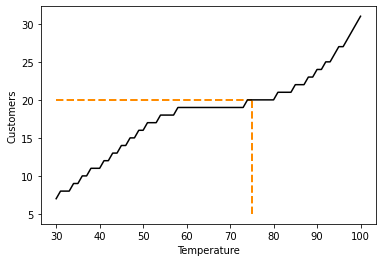

In [11]:
# Number of customers on our hypothetical 75 degree day
plt.plot(temp, predicted_customers, 'k')
plt.vlines(75, 5, predicted_customers[temp == 75], color='DarkOrange', linestyle='dashed', lw=2)
plt.hlines(predicted_customers[temp == 75], 30, 75, color='DarkOrange', linestyle='dashed', lw=2)
plt.xlabel('Temperature')
plt.ylabel('Customers');

Look at this beautiful, nonlinear, intuitive response! Easy to build, easy to tweak, and we retained intuition throughout.

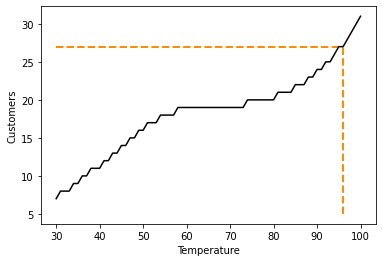

In [12]:
# Number of customers on our real Texas day: 96 degrees
plt.plot(temp, predicted_customers, 'k')
plt.vlines(96, 5, predicted_customers[temp == 96], color='DarkOrange', linestyle='dashed', lw=2)
plt.hlines(predicted_customers[temp == 96], 30, 96, color='DarkOrange', linestyle='dashed', lw=2)
plt.xlabel('Temperature')
plt.ylabel('Customers');

##Exercises: 

1. Go back and re-calculate the relation using `fuzz.relation_min` instead of `fuzz.relation_product`.

* What changes? 
* Which model do you think is better? (warning: trick question)

2. Adjust the parameters of the original membership functions and re-run the notebook. Do the results make intuitive sense?